In [2]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import astropy as ast
from astropy import stats



import SessionTools.two_photon as st2p

plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 


%matplotlib inline

In [3]:

basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/R60D05LexA_jGCaMP7b_R18B05Gal4_TBHRNAi')
sess_df = pd.read_csv(basedir / 'sessions.csv')
print(sess_df.columns)
sess_df['fly_id'] = [row['date']+'_'+row['fly'] +'_' + row['gal4_line'] + '_' + row['rnai_line '] for _, row in sess_df.iterrows()]
figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/LabMeetings/05_09_2024/R60D05LexA_jGCaMP7b_R18B05Gal4_TBHRNAi/')

figfolder.mkdir(parents=True, exist_ok=True)

sess_df = sess_df.loc[sess_df['usable']==1]

Index(['date', 'fly', 'sess', 'fictrac_scan_num', 'closed_loop', 'dark',
       'rnai_line ', 'gal4_line', 'usable', 'fictrac_dat_file', 'notes'],
      dtype='object')


In [4]:
stats_df = {'fly_id': [],
           'cl': [],
           'rnai': [],
            'gal4': [],
            # 'corr': [],
            'dark': [],
           'offset_var':[]}


for _,row in sess_df.iterrows():
    if row['usable']==1:
        if row['gal4_line']!='control':
            outdir = pathlib.PurePath( basedir / row['rnai_line '] / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
        else:
            outdir = pathlib.PurePath( basedir / 'gal4_control' / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')

        # print(outdir)
        pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
        y = pp.calculate_zscored_F('rois', exp_detrend=True, zscore=True)
        
        dff = pp.timeseries['rois_z'][-1,:,:]-1
        # print(dff.shape)
        
        heading = -1*pp.voltage_recording_aligned[' Heading'].to_numpy()
        h_mask = np.abs(heading)>1
        
        x_f,y_f = st2p.utilities.pol2cart(dff ,np.linspace(-np.pi,np.pi,num=dff.shape[0])[:,np.newaxis])
        rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))
        
        _,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))
        
       
        
        stats_df['fly_id'].append(row['fly_id'])
        stats_df['cl'].append(row['closed_loop'])
        stats_df['dark'].append(row['dark'])
        stats_df['rnai'].append(row['rnai_line '])
        stats_df['gal4'].append(row['gal4_line'])
       
        
        stats_df['offset_var'].append(sp.stats.circvar(offset[h_mask]))
       
stats_df = pd.DataFrame.from_dict(stats_df)

In [5]:
fly_ids = stats_df['fly_id'].unique()

rnai_ids = np.zeros((len(fly_ids),))
for i, fly in enumerate(fly_ids):
    rnaistate = stats_df['rnai'].loc[stats_df['fly_id']==fly].iloc[0]
    gal4state = stats_df['gal4'].loc[stats_df['fly_id']==fly].iloc[0]
    if ('control' in rnaistate) and ('R18B05' in gal4state):
        rnai_ids[i]=0
    elif ('rnai_67968' in rnaistate) and ('R18B05' in gal4state):
        rnai_ids[i]=1
    elif ('control' in gal4state) and ('rnai_67968' in rnaistate):
        rnai_ids[i]=2
    else:
        rnai_ids[i]=-1

print(fly_ids,rnai_ids)

['29_03_2024_fly2_R18B05_rnai_67968' '01_04_2024_fly1_R18B05_rnai_67968'
 '03_04_2024_fly1_R18B05_rnai_67968' '28_03_2024_fly1_R18B05_control'
 '29_03_2024_fly1_R18B05_control' '02_04_2024_fly2_R18B05_control'
 '29_03_2024_fly1_R18B05_rnai_76062' '01_04_2024_fly1_R18B05_rnai_76062'
 '02_04_2024_fly1_R18B05_rnai_76062' '04_04_2024_fly1_R18B05_rnai_76062'
 '05_04_2024_fly1_R18B05_control' '07_04_2024_fly2_R18B05_control'
 '05_04_2024_fly1_R18B05_rnai_67968' '07_04_2024_fly1_R18B05_rnai_67968'
 '05_04_2024_fly1_R18B05_rnai_76062' '22_04_2024_fly1_R18B05_control'
 '22_04_2024_fly1_R18B05_rnai_67968' '23_04_2024_fly1_R18B05_control'
 '23_04_2024_fly2_R18B05_control' '23_04_2024_fly2_R18B05_rnai_67968'
 '24_04_2024_fly1_R18B05_rnai_67968' '24_04_2024_fly2_R18B05_rnai_67968'
 '25_04_2024_fly2_R18B05_control' '25_04_2024_fly3_R18B05_control'
 '26_04_2024_fly1_R18B05_control' '26_04_2024_fly1_R18B05_rnai_67968'
 '07_06_2024_fly2_control_rnai_67968' '10_06_2024_fly1_control_rnai_67968'
 '10_06_2

0.0 0.001953125
17.0 0.5703125
0.0 0.0002797002701866865
24.0 0.09416637543787974
88.0 0.0005202443475902288
0.0 0.001953125
88.0 0.0005202443475902288
[[0.4644033  0.73621298]
 [0.33192936 0.77222461]
 [0.66076798 0.69607425]
 [0.29537142 0.84819447]
 [0.59487092 0.88873358]
 [0.67706057 0.91123234]
 [0.35009212 0.86988334]
 [0.60455503 0.85430634]
 [0.38856203 0.82080636]
 [0.55179362 0.67592864]]


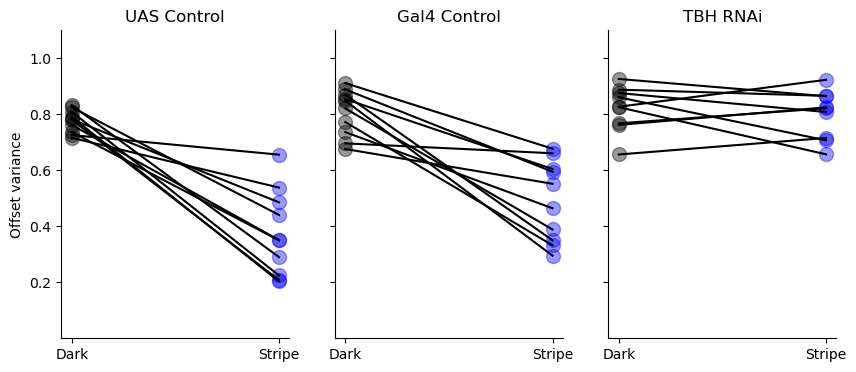

In [7]:
fly_avgs = np.nan*np.zeros((len(fly_ids),2))
for r, fly in enumerate(fly_ids):
    
    mask = (stats_df['fly_id']==fly)*(stats_df['cl']>1)
    # print(stats_df.loc[mask])
    cl = stats_df['offset_var'].loc[mask].mean()
    # fly_avgs[r,0]=cl
    
    mask = (stats_df['fly_id']==fly)*(stats_df['dark']>=1)
    dark = stats_df['offset_var'].loc[mask].mean()
    # fly_avgs[r,1] = dark
    
    if np.isnan(cl) or np.isnan(dark):
        pass
    else:
        fly_avgs[r,0] = cl
        fly_avgs[r,1] = dark
    

fig,ax = plt.subplots(1,3,sharey=True, figsize=[10,4])

c_h = ax[0].plot([0,1],fly_avgs[rnai_ids==0,::-1].T, color='black')
ax[0].scatter(np.zeros(((rnai_ids==0).sum(),)),fly_avgs[rnai_ids==0,-1], color='black', alpha=.4,s=100)
ax[0].scatter(np.ones(((rnai_ids==0).sum(),)),fly_avgs[rnai_ids==0,0], color='blue', alpha=.4,s=100)


d_h = ax[2].plot([0,1],fly_avgs[rnai_ids==1,::-1].T, color='black')
ax[2].scatter(np.zeros(((rnai_ids==1).sum(),)),fly_avgs[rnai_ids==1,-1], color='black', alpha=.4,s=100)
ax[2].scatter(np.ones(((rnai_ids==1).sum(),)),fly_avgs[rnai_ids==1,0], color='blue', alpha=.4,s=100)

c_h = ax[1].plot([0,1], fly_avgs[rnai_ids==2,::-1].T, color='black')
ax[1].scatter(np.zeros(((rnai_ids==2).sum(),)),fly_avgs[rnai_ids==2,-1], color='black', alpha=.4,s=100)
ax[1].scatter(np.ones(((rnai_ids==2).sum(),)),fly_avgs[rnai_ids==2,0], color='blue', alpha=.4,s=100)


t,p = sp.stats.wilcoxon(fly_avgs[rnai_ids==0,0], fly_avgs[rnai_ids==0,1], nan_policy='omit')
print(t,p)

t,p = sp.stats.wilcoxon(fly_avgs[rnai_ids==1,0], fly_avgs[rnai_ids==1,1], nan_policy='omit')
print(t,p)

t,p = sp.stats.mannwhitneyu(fly_avgs[rnai_ids==0,0], fly_avgs[rnai_ids==1,0], nan_policy='omit')
print(t,p)

t,p = sp.stats.mannwhitneyu(fly_avgs[rnai_ids==0,1], fly_avgs[rnai_ids==1,1], nan_policy='omit')
print(t,p)

diff = fly_avgs[:,1]-fly_avgs[:,0]
t,p = sp.stats.mannwhitneyu(diff[rnai_ids==0], diff[rnai_ids==1], nan_policy='omit')
print(t,p)

t,p = sp.stats.wilcoxon(fly_avgs[rnai_ids==2,0], fly_avgs[rnai_ids==2,1], nan_policy='omit')
print(t,p)

t,p = sp.stats.mannwhitneyu(fly_avgs[rnai_ids==1,0], fly_avgs[rnai_ids==2,0], nan_policy='omit')
print(t,p)

print(fly_avgs[rnai_ids==2,:])


for i in range(3):
    ax[i].set_ylim([0.0,1.1])
    ax[i].set_yticks([.2,.4,.6,.8,1.])

    ax[i].set_xticks([0, 1], labels=['Dark', 'Stripe'])
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    
ax[0].set_ylabel('Offset variance')
ax[0].set_title('UAS Control')
ax[2].set_title('TBH RNAi')
ax[1].set_title('Gal4 Control')

fig.savefig(figfolder / 'TBH_summary.pdf')

In [15]:
np.sum(fly_avgs[rnai_ids==2,:]>0,axis=0)

array([10, 10])